# Custom NN modeling

### 1. Load Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

train = pd.read_csv('../../data/prepared_train.csv')
test = pd.read_csv('../../data/prepared_test.csv')

### 2. Train, Validation, Test split

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

group = ['lane_count', 'road_rating', 'weight_restricted', 'maximum_speed_limit']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in split.split(train, train[group]):
    train_set = train.loc[train_index]
    val_set = train.loc[val_index]

### 3. Scaling

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_ = scaler.fit_transform(train_set.loc[:, train_set.columns != 'target'])
train_ = pd.DataFrame(train_, columns=train_set.columns.drop('target').values)
train_['target'] = train_set[['target']].values
train_set = train_
train_ = 0

val_ = scaler.transform(val_set.loc[:, val_set.columns != 'target'])
val_ = pd.DataFrame(val_, columns=val_set.columns.drop('target').values)
val_['target'] = val_set[['target']].values
val_set = val_
val_ = 0

test_ = scaler.transform(test)
test_ = pd.DataFrame(test_, columns=test.columns)
test = test_
test_ = 0

### 4. DataLoader

In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.X = torch.tensor(dataset.loc[:, dataset.columns != 'target'].values, dtype=torch.float32, device="cuda")
        self.y = torch.tensor(dataset.loc[:, dataset.columns == 'target'].values, dtype=torch.float32, device="cuda")
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
_train = CustomDataset(train_set)
_valid = CustomDataset(val_set)
_test = CustomDataset(test)

trainloader = DataLoader(_train, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
validloader = DataLoader(_valid, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
testloader = DataLoader(_test, batch_size=1, shuffle=False, num_workers=0)

### 5. Custom Neural Network

In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(33, 25)
        self.bn1 = nn.BatchNorm1d(25)
        self.drop1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(25, 18)
        self.bn2 = nn.BatchNorm1d(18)
        self.drop2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(18, 10)
        self.bn3 = nn.BatchNorm1d(10)
        self.drop3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(10, 5)
        self.bn4 = nn.BatchNorm1d(5)
        self.drop4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(5, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop3(x)
        x = F.relu(self.fc4(x))
        x = self.drop4(x)
        x = self.fc5(x)
        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNet().to(device)
print(model)

SimpleNet(
  (fc1): Linear(in_features=33, out_features=25, bias=True)
  (bn1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=25, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=10, out_features=5, bias=True)
  (bn4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout(p=0.5, inplace=False)
  (fc5): Linear(in_features=5, out_features=1, bias=True)
)


### 6. Loss function & Optimizer

In [8]:
import torch.optim as optim

learning_rate = 0.001
momentum = 0.09

criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

### 7. Train

In [9]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

num_epochs = 10
dataloader = {
    'train': trainloader,
    'valid': validloader,
}

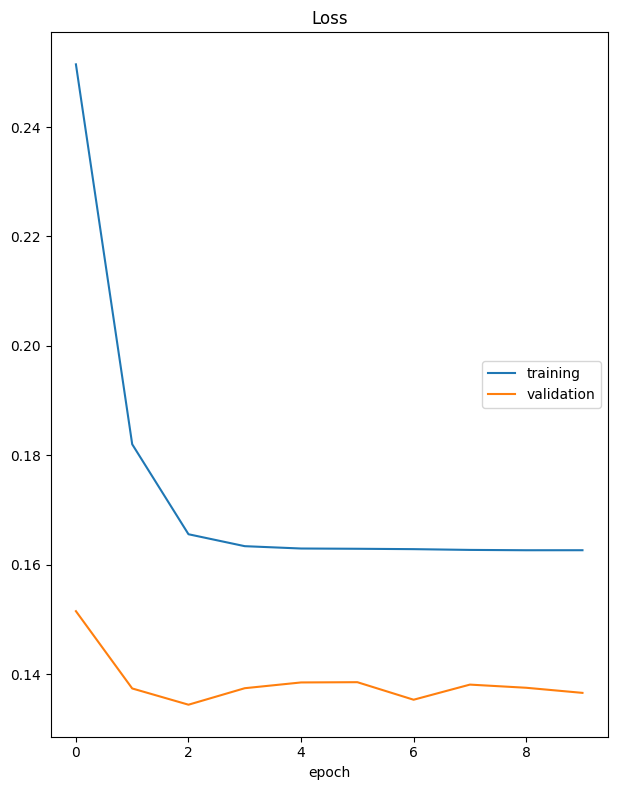

Loss
	training         	 (min:    0.163, max:    0.251, cur:    0.163)
	validation       	 (min:    0.134, max:    0.152, cur:    0.137)


In [10]:
liveloss = PlotLosses()

for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        accum_loss = 0
        cur_loss = 0
        for i, (data, labels) in enumerate(dataloader[phase]):
            inputs = data.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            cur_loss += loss.item()
            accum_loss += loss.item()
            
            if (phase == 'train') & (i % 5000 == 4999):
                print(f'[{epoch + 1}, {i + 1}] loss: {cur_loss / 5000:.3f}')
                cur_loss = 0
            elif (phase == 'valid') & (i % 2000 == 1999):
                print(f'[{epoch + 1}, {i + 1}] loss: {cur_loss / 2000:.3f}')
                cur_loss = 0                
                
        epoch_loss = accum_loss / len(dataloader[phase].dataset)
        
        prefix = ''
        if phase == 'valid':
            prefix = 'val_'
            
        logs[prefix + 'loss'] = epoch_loss

    liveloss.update(logs)
    liveloss.send()

### 8. Evaluation

In [11]:
model_path = '../../data/custom_nn.pth'
torch.save(model.state_dict(), model_path)

model = SimpleNet().to(device)
model.load_state_dict(torch.load(model_path))

submission = '../../data/sample_submission.csv'

results = pd.read_csv(submission)

In [12]:
model.eval()
with torch.no_grad():
    for i, (data, _) in enumerate(testloader):
        inputs = data
        outputs = model(inputs)
        results.loc[i, ['target']] = outputs.cpu().detach().numpy()[0][0]

In [13]:
results.to_csv('../../data/sample_submission_custom.csv', index=False)